# Capstone project by David Fischer 

# Predicting airbnb prices in Melbourne. Do house prices, crime rates and neighbouring airbnb prices help to predict airbnb prices?

Submitted in July 2020

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor 
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
import copy
import xgboost as xgb
import statsmodels.api as sm
import os
import seaborn as sns
import pickle
from heapq import nsmallest

import warnings
warnings.filterwarnings('ignore')

# own modules
from capstone_project import airbnb_data as air
from capstone_project import housing_data as house
from capstone_project import crime_data as crime

%matplotlib inline

## 0) Set-up

### Style

In [2]:
# Plot style
#plt.style.use('seaborn-notebook')
#print(plt.style.available)

# Colors
col1 = 'royalblue'
col2 = 'crimson'

### Own and other additional packages

**Own package**  

There is an own package called `capstone_project`. The package contains of the three modules `airbnb_data`, `housing_data` and `crime_data` where functions are defined to import, clean and aggregate the data. The function `_haversine_np()` in `airbnb_data` and `housing_data` is taken from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas. All other functions in this package are my own work:

    capstone_project/:
                        airbnb_data.py
                        housing_data.py
                        crime_data.py

The most important functions are `_circle_candidates()`, `circle_observations()`, `aggregate_airbnb_data_circles()`, `the_nearest_obs()`, `the_nearest_obs_prices()`, `the_nearest_obs_housing()` and `the_nearest_obs_housing_prices()`. In these functions the whole logic of selecting observations and aggregating prices is implemented.

**Additional package**

`xgboost` is additionally installed on `exts-ml` so that we can learn models based on extreme gradient boosting (https://xgboost.readthedocs.io/en/latest/python/index.html):
     
    conda install -n exts-ml -c conda-forge --freeze-installed xgboost 
        
<!--- conda install -n exts-ml -c calex --freeze-installed sklearn-pandas (not available) --->

## 1) The problem

In real estate a often stated mantra is *location, location, location*, which highlights the fact that the location is of great importance for house prices. It is likely that this finding also holds for airbnb data. Indeed, a first look at the log airbnb prices for different suburbs in Melbourne show some differences:

In [3]:
mean = pickle.load(open("airbnb_agg_wo_outliers.p", "rb"))
var = pickle.load(open("airbnb_agg_wo_outliers_var.p", "rb"))
count = pickle.load(open("airbnb_agg_wo_outliers_count.p", "rb"))

data = mean.merge(var, left_on='Air_neighbourhood_cleansed', right_on='Air_neighbourhood_cleansed',
                 suffixes=('_mean', '_var'))

data = data.merge(count, left_on='Air_neighbourhood_cleansed', right_on='Air_neighbourhood_cleansed',
                 suffixes=('', '_count'))
data.rename(columns={'Air_log_price_Entire home/apt': 'Air_log_price_Entire home/apt_count',
                    'Air_log_price_Private room': 'Air_log_price_Private room_count',
                    'Air_log_price_Shared room': 'Air_log_price_Shared room_count'},
           inplace=True)

data['Air_log_price_Entire home/apt_std_err'] = (data['Air_log_price_Entire home/apt_var'] / \
                                                data['Air_log_price_Entire home/apt_count']).pow(0.5)
data['Air_log_price_Private room_std_err'] = (data['Air_log_price_Private room_var'] / \
                                                data['Air_log_price_Private room_count']).pow(0.5)
data['Air_log_price_Shared room_std_err'] = (data['Air_log_price_Shared room_var'] / \
                                                data['Air_log_price_Shared room_count']).pow(0.5)

data.sort_values(by='Air_log_price_Entire home/apt_mean', inplace=True)

data.loc[:, ['Air_log_price_Entire home/apt_mean', 'Air_log_price_Entire home/apt_std_err', 
            'Air_log_price_Private room_mean', 'Air_log_price_Private room_std_err',
            'Air_log_price_Shared room_mean', 'Air_log_price_Shared room_std_err']].head(5)

,Air_log_price_Entire home/apt_mean,Air_log_price_Entire home/apt_std_err,Air_log_price_Private room_mean,Air_log_price_Private room_std_err,Air_log_price_Shared room_mean,Air_log_price_Shared room_std_err
3,1.910950,0.053272,1.689408,0.025630,NaN,NaN
9,1.976709,0.048811,1.688160,0.016321,1.588046,0.110924
16,1.981036,0.038924,1.741996,0.031190,1.508717,0.042179
26,1.991422,0.060083,1.686498,0.021913,1.612655,0.068587
0,1.997895,0.022308,1.686678,0.017221,1.642748,0.112309


In [4]:
data.loc[:, ['Air_log_price_Entire home/apt_mean', 'Air_log_price_Entire home/apt_std_err', 
            'Air_log_price_Private room_mean', 'Air_log_price_Private room_std_err',
            'Air_log_price_Shared room_mean', 'Air_log_price_Shared room_std_err']].tail(5)

,Air_log_price_Entire home/apt_mean,Air_log_price_Entire home/apt_std_err,Air_log_price_Private room_mean,Air_log_price_Private room_std_err,Air_log_price_Shared room_mean,Air_log_price_Shared room_std_err
1,2.142325,0.017239,1.852359,0.019135,1.720511,0.108794
14,2.151074,0.017166,1.842334,0.018742,1.673614,0.101055
18,2.160544,0.043121,1.742659,0.027417,1.849485,0.150515
4,2.191106,0.026774,1.951160,0.034945,1.602060,NaN
29,2.261924,0.008990,2.043623,0.019825,NaN,NaN


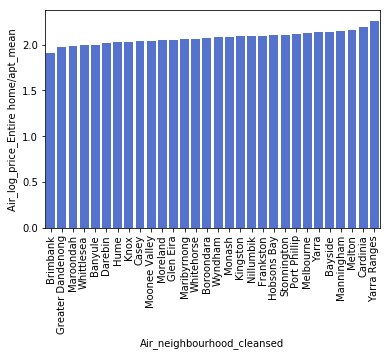

In [5]:
ax = sns.barplot(x="Air_neighbourhood_cleansed", y="Air_log_price_Entire home/apt_mean", data=data, color=col1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

From the table above we observe that the differences between the means are small. However, the standard errors of the estimations are small too. Without using statistical tests there seems to be some evidence that airbnb prices might be differ among neighbourhoods. 

Even if we correctly assume that the prices are different between suburbs we do not know what causes these differences. Possible reasons are for example that some suburbs are located nearer to the centre - also known as the Melbourne city centre or CBD - or the seadside, or are safer. People may value these attributes and are willing to pay higher prices. 

The goal of this project is to predict airbnb prices. One question of interest is whether we can improve the accuracy of our predictions when additional data on house prices, crime rates or other information related to the neighbourhood as for example the airbnb prices within a given radius from the reference observation are taken into account. Regarding crimes, Xu, Kim and Pennington-Gray (student project) conclude that "Airbnb is positively related to property crime and negatively related to violent crime" (p. 9). A high proportion of property crimes could thus be a proxy for high demand for airbnb accommondations, which positively affects prices if supply falls short. For the City of Melbourne provides this unique set of information is available.

<!---The goal of this project is to shed light on how external data about housing prices and crime rates can be used to improve **predictions** of airbnb prices. There are two questions of interest:--->
The following research questions summarizes our goal.
<!---1. Is it possible to replace the neighbourhood and suburb variable in the airbnb dataset by external variables from either from the housing market or from the crime statistics provided by the City of Melbourne to achieve the same prediction accuracy? -->
1. Are external data as housing prices or information about crime rates helpful to predict airbnb prices?
<!---2. Can a better performance be achieved if the information about the longitude and latitude is used to aggregate the external data because aggregations could be finer and more appropriate (see the illustration)?--->
2. Can predictions be improved if data of neighbouring airbnb or house prices are aggregated in a finer way based on the exact location represented by the longitude and latitude? 

The idea behind question 2) is illustrated in Fig. 1. The aggregation can also be done w.r.t. another variable as for instance the room or the property type. In such a set-up we could end up for example in aggregating all airbnb prices of the same room type that are located within a given radius. 

<!--- https://stackoverflow.com/questions/14675913/changing-image-size-in-markdown 
https://www.w3schools.com/tags/tag_figcaption.asp
--->
<center>
<img src="/Images/Fig_1.png" alt="drawing" width="350"/>
    <figcaption> <b> Fig. 1: </b> Constructed aggregation of neighbouring accommodations. </figcaption>
</center>

<br>

Literature <br>
- XU, Yua-Hua; Kim, Jim-won; and Pennington-Gray, Lori, "Explore the Spatial Relationship between Airbnb Rental and Crime" (2017). *Travel and Tourism Research Association: Advancing Tourism Research Globally. 5.*

### Methodology

Next, we need to find a computationllay feasable way to select observations that lie within a given radius to the reference observation. A possible way is to construct a square represented by the differences in longitude and latitude from the reference observation that surrounds the circle of interest and then to select the observations that lie within the circle. Therefore, we need to find a way to derive the differences in longitude and latitude given a radius measured in meters, kilometers or another distance measure.

From the literature it is known that the distance in km between two points with longitude and latitude measured in radians is given by (https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas):

$$ d = 6367 \times 2 \times  \arcsin \Big(\sqrt{\sin(d_{lat}/2 )^2 + \cos(lat_1) \times \cos(lat_2) \times \sin(d_{lon}/2)^2} \Big)$$

where $d_{lon} := lon_2 - lon_1$ and $d_{lat} := lat_2 - lat_1$.

For this project we start with a distance $d_{max}$ to then calculate:

\begin{align}
d_{lon} &= 2 \times \arcsin\Big( \sqrt{ \arcsin(a/\cos(lat_1)^2) } \Big) \\
d_{lat} &= 2 \times \arcsin\Big(\sqrt{a}\Big)
\end{align}

given that $d_{lat} = 0$ and $d_{lon} = 0$, respectively, where $a = \sin(d_{max} / (6367 \times 2))^2$ in order to extract candidates, which are then tested with the distance formula. The approach is graphically illustrated in Fig. 2.

<center>
<img src="/Images/Fig_2.png" alt="drawing" width="350"/>
    <figcaption> <b> Fig. 2: </b> The approach to select neighbouring accommodations. </figcaption>
</center>

### Uniqueness of the work and related projects

There are many projects that deal with airbnb data in general or Melbourne housing data. This work is to my knowledge unique in two ways:
1. None of the project so far focuses on additional data as we do by investigating whether airbnb prices are influenced or just correlated by house prices or crime rates.
2. We deal with alternative forms of prices aggregations, e.g by selecting neighbouring accommodations or house that lie within a circle and are of the same kind, e.g. same room, property (airbnb dataset) or house type (housing dataset).

We are going to see that idea 1) does not and idea 2) does help to improve predictions. 

**Related works w.r.t the datasets**

*housing_market:*

- https://rpubs.com/kunaljubce/mlb_housing_data

*airbnb:*

- https://medium.com/datadriveninvestor/exploratory-data-analysis-on-airbnb-properties-in-paris-bce61bd680c8
- https://medium.com/@jeffrisandy/where-to-stay-in-beijing-airbnb-795bb184acd7